# IMPORTS

In [1]:
import networkx as nx
import random
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import copy

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go

from itertools import product
from dwave.embedding import pegasus
import dwave.inspector
import minorminer
import dwave_networkx as dnx

import gurobipy as gb
from gurobipy import GRB

# Graph generation and pruning

## Functions

### Graph construction

In [2]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

    instance = {}
    machine_list = list(range(n_machine))

    for i in range(n_job):
        random.shuffle(machine_list)
        instance[i] = []
        for j in range(n_machine):
            instance[i].append((machine_list[j], random.randint(1,max_duration)))
    instance['timespan'] = timespan
    
    return instance

In [3]:


def get_variables(instance):

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1

    variables = np.zeros((n_machines, n_jobs, instance['timespan']))
    
    return variables


Here we start building the backbone of the graphe inserting every a node for every variable.
The positions of the nodes are set in a way that organizes them in the following way:

1 block for every machine. 

For every machine a column for every job.

Every block has a number of lines equal to the timespan considered.


In [4]:
def build_graph(instance):
    graph = nx.Graph()
    job_groups = {}

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

    #this dictionary {job:(nodes of task1), (nodes of task2), (nodes of task3)} is needed for visualiziong the graph
    task_groups = {}

    m_seq = {}

    for job in range(n_jobs):
        m_seq[job] = []
        for task in instance[job]:
                m_seq[job].append(task[0])

    for job in m_seq:
        task_groups[job] = []
        
        for m in m_seq[job]:
                tmp = []

                for node in job_groups[job]:
                    if m == node[0]:
                            tmp.append(node)

                task_groups[job].append(tmp)


    #this dictionary {node:position} is needed for visualizing the graph
    pos_dict = {}

    for n in graph.nodes:
        pos_dict[n] = graph.nodes[n]['pos']


    return graph, task_groups, pos_dict

### Edge Constraints Generation

This function generates the edges relative to the START ONLY ONCE constraint.

The mathematical formulation of this constraint is:
$$ \sum_i(\sum_t x_{i,t} -1)^2 $$

And so we have an edge for every pair $x_{i,t}, x_{i,p}$ where $p \neq t$

This kind of edges are orange in the final plots

In [5]:
def soo_edges(instance):
    curved_edges = []
    straight_edges = []

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    
    for m in range(n_machines):
        for j in range(n_jobs):
            for t in range(timespan-1):
                for k in range(t+1,timespan):
                    if abs(t-k) > 1:
                        curved_edges.append(((m,j,t),(m,j,k)))
                    else:
                        straight_edges.append(((m,j,t),(m,j,k)))
    
    return curved_edges, straight_edges

This function generates the edges relative to the OPERATION ORDER constraint.

The mathematical formulation of this constraint is:

$$ \sum_{ k_{n-1}<i<k_n \atop t+p_i > t'}  x_{i,t}x_{i+1,t'}$$

In [6]:
def oo_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for job in range(n_jobs):
        for i in range(n_machines-1):
            task = instance[job][i]
            m = task[0]
            p = task[1]
            for t in range(timespan):
                t_max = min(t + p, timespan)
                for t_p in range(t_max):
                    task_p = instance[job][i+1]
                    m_p = task_p[0]
                    p_p = task_p[1]

                    edges.append(((m,job,t),(m_p,job,t_p)))
        
    return edges

This set of functions generates the edges relative to the OPERATION ORDER constraint.

The mathematical formulation of this constraint is:
$$\sum_{(i,t,k,t')\in R_m} x_{i,t}x_{k,t'} $$

where $R_m = A_m \cup B_m$ (here $B_m is not yet present, it is needed for the generalization where p=0)

And $A_m = \{(i,t,k,t'): (i,k) \in I_M \times I_M, \\ \qquad \qquad i \neq j,\\ \qquad \qquad 0\leq t,\\ \qquad \qquad t'\leq T,\\ \qquad \qquad 0<t'-t<p_i  \}$

where $I_M$ is the set of all tasks that need the machine M to run.

In [7]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for task in instance[job]:
            if task[0] == m:
                I_m.add((m,job))
    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)
    '''
    tmp = list(I_mx)
    for e in tmp:
        if (e[1], e[0]) in I_mx:
            I_mx.remove(e)
    '''
            
    return I_mx

In [8]:
def A_set(instance, m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_mx = I_set(instance, m)

    A_m = set()

    for e in I_mx:
        
        job = e[0][1]
        for t in instance[job]:
            if t[0] == m:
                p = t[1]
        
        for t in range(timespan):
            for t_p in range(timespan):
                if (0<=t_p - t) and (t_p-t<p):
                    new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
                    A_m.add(new_el)
    return A_m
    


In [9]:
def otm_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for m in range(n_machines):
        R_m = A_set(instance, m)
        for e in R_m:
            edges.append((e[0], e[1]))
    
    return edges

### Pruning

In [10]:
def simple_pruning(instance, graph, pos_dict, task_groups, edge_groups):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    graph = copy.deepcopy(graph)

    ext_instance = copy.deepcopy(instance)
    edge_groups = copy.deepcopy(edge_groups)
    task_groups = copy.deepcopy(task_groups)
    pos_dict = copy.deepcopy(pos_dict)

    #head and tail comp
    for job in range(n_jobs):
        for t_idx,task in enumerate(instance[job]):
            p_task = task[1]
            m_task = task[0]
            #single job upperbound
            tail = timespan
            for i in range(t_idx, n_machines):
                tail -= instance[job][i][1]

            #single job lowerbuond
            head = 0
            for i in range(t_idx):
                head += instance[job][i][1]

            ext_instance[job][t_idx] += (head,tail)
    
    tmp_instance = copy.deepcopy(ext_instance)
    '''
    #single machine upperbound
    for job in range(n_jobs):
        for task_idx, task in enumerate(ext_instance[job]):
            m_task = task[0]
            for j in range(n_jobs):
                for t in ext_instance[job]:
                    if (m_task == t[0]) and (task[2] + task[1] + t[1] + t[3] > timespan):
                        tmp = list(tmp_instance[job][task_idx])
                        tmp[2] = max(task[2], t[2]+t[1])
                        tmp_instance[job][task_idx] = tuple(tmp)
    '''
    ext_instance = tmp_instance
    
    rm_nodes = []
    for job in range(n_jobs):
        for task in ext_instance[job]:

            #node removal
            for node in graph.nodes:
                if (node[0] == task[0]) and (node[1] == job) and ((node[2] < task[2] ) or (node[2] > task[3])):
                    rm_nodes.append(node)
    for r in rm_nodes:
        graph.remove_node(r)

    #edge removal
    rm_edges = []
    for edge in graph.nodes:
        for r in rm_nodes:
            if r in edge:
                rm_edges.append(edge)
    for r in rm_edges:
        graph.remove_edge(r)

    #pos removal
    rm_pos = []
    for k in pos_dict:
        if k in rm_nodes:
            rm_pos.append(k)
    for r in rm_pos:
        del pos_dict[r]

    #node groups removal
    for j in task_groups:
        for  i,g in enumerate(task_groups[j]):
            rm_task = []
            for n in g:
                if n in rm_nodes:
                    rm_task.append(n)
            for r in rm_task:
                task_groups[j][i].remove(r)

    #edge groups removal
    for i,group in enumerate(edge_groups):
        rm_edgegroup = []
        
        for edge in group:
            for node in rm_nodes:
                if (node in edge) and (edge not in rm_edgegroup):
                    rm_edgegroup.append(edge)
        for r in rm_edgegroup:
            edge_groups[i].remove(r)
    
    return graph, ext_instance, pos_dict, task_groups, edge_groups

## Execution

### Instance generation

In [11]:
instance = {
    0: [(0,2), (1,1), (2,1)],
    1: [(2,2), (0,1), (1,2)],
    2: [(1,1), (0,1), (2,2)],
    'timespan': 6
}

In [122]:
instance

{0: [(0, 2), (1, 1), (2, 1)],
 1: [(2, 2), (0, 1), (1, 2)],
 2: [(1, 1), (0, 1), (2, 2)],
 'timespan': 6}

In [22]:
n_jobs = 2
n_machines = 2
max_duration = 2
timespan = 4

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)
instance

{0: [(0, 1), (1, 2)], 1: [(0, 2), (1, 2)], 'timespan': 4}

### Graph generation and pruning

In [12]:
graph, task_groups, pos_dict = build_graph(instance)
otm_straight = otm_edges(instance)
soo_curved, soo_straight = soo_edges(instance)
oo_straight = oo_edges(instance)

graph.add_edges_from(soo_curved)
graph.add_edges_from(soo_straight)
graph.add_edges_from(oo_straight)
graph.add_edges_from(otm_straight)

edge_groups = [soo_curved, soo_straight, otm_straight, oo_straight]

graph2, ext_instance, pos_dict2, task_groups2, edge_groups2 = simple_pruning(instance, graph, pos_dict, task_groups, edge_groups)

## Plotting

In [13]:
cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
cmap_edges = matplotlib.colormaps.get_cmap('Dark2')
linewidth = 2
node_size = 400
node_alpha = 0.7
edge_alpha = 0.5

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


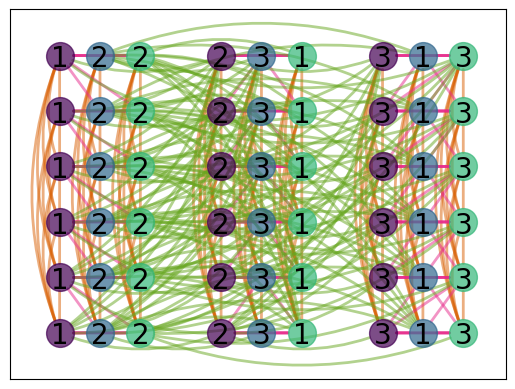

In [14]:
##FULL GRAPH PLOT


for job in task_groups:
    for i,task in enumerate(task_groups[job]):
        nx.draw_networkx_nodes(graph, pos_dict, node_size=node_size, nodelist=task, node_color=cmap_nodes(job/len(task_groups)), alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph, pos_dict, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_curved, arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_straight, arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=otm_straight, arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=oo_straight, arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()

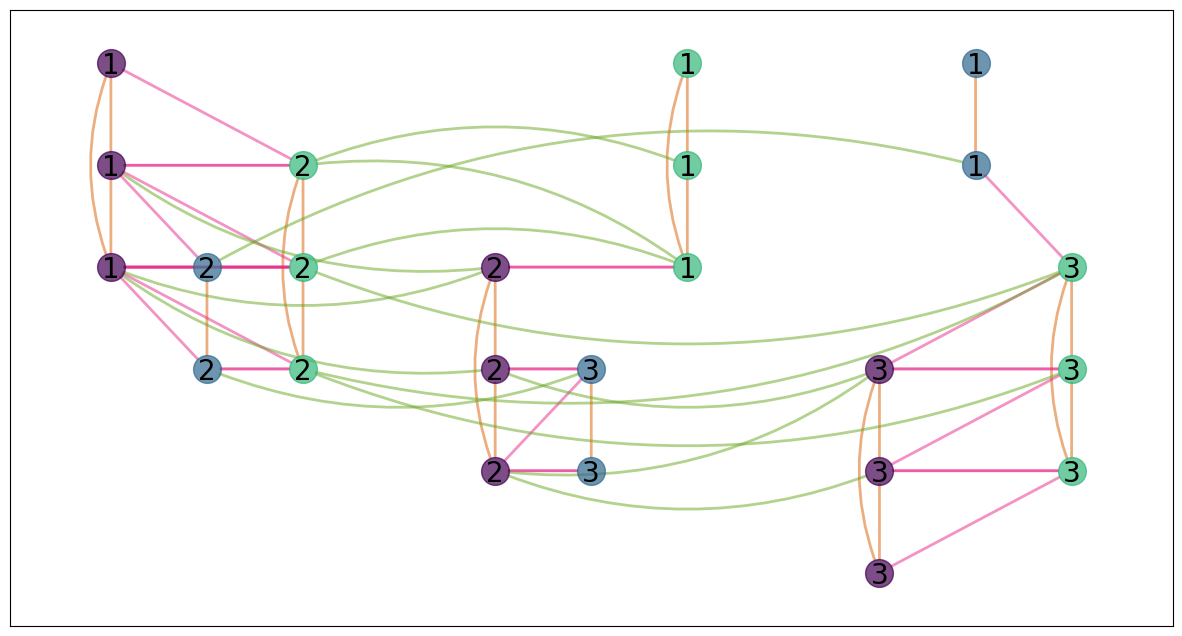

In [15]:
#PRUNED GRAPH PLOTTING

plt.figure(figsize=(15,8))
for job in task_groups2:
    for i,task in enumerate(task_groups2[job]):
        nx.draw_networkx_nodes(graph2, pos_dict2, node_size=node_size, nodelist=task, node_color=cmap_nodes(job/len(task_groups)), alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph, pos_dict2, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[0], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[1], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[2], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[3], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()

# Embedding

In [16]:
#TARGET GRAPH

target = dnx.pegasus_graph(2)

In [17]:
chains = nx.all_simple_paths(target,2,4,3)
list(chains)

[]

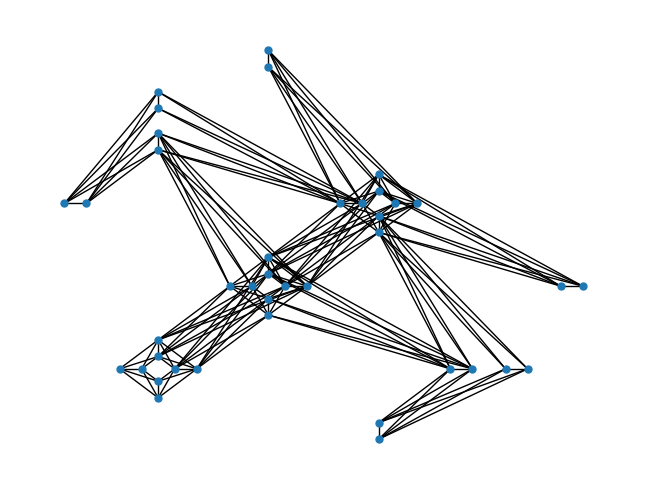

In [18]:
dnx.draw_pegasus(target, node_size=25, crosses=True)

## DWave default minor-embedding

In [20]:
#DWAVE default minor-embedding

embedding = minorminer.find_embedding(graph2, target)

if len(embedding.keys()) == 0:
    print('Embedding failed')
else:
    print('Embedding succesful')

Embedding succesful


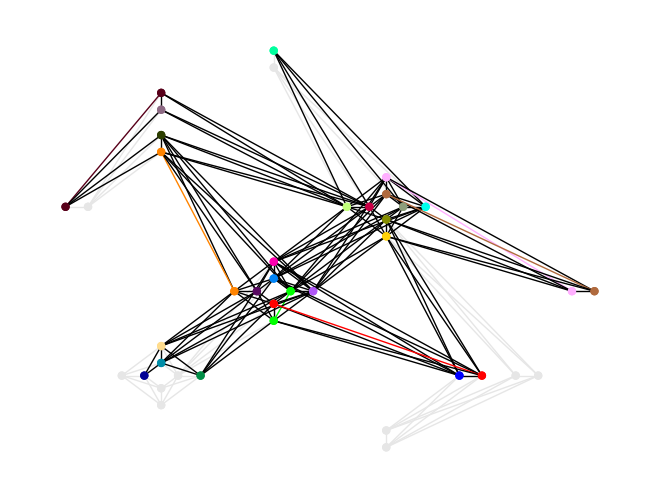

In [21]:
dnx.draw_pegasus_embedding(target, embedding, node_size=25, crosses=True)

## IP minor-embedding

### Functions

In [24]:
def define_decision_variables(target, graph, model):

    var_dict = {}
    for v in target.nodes:
        for w in graph.nodes:
            var_dict[(v,w)] = model.addVar(vtype=GRB.BINARY, name=f'x_{v},{w}')
    return var_dict

In [23]:
def define_gamma_variables(chains, j, k, var_dict, model):
    ls = []
    for c in chains:
        ls.append(model.addVar(vtype=GRB.BINARY, name=f'gamma_{c}_{j}'))

        s = 0
        for i in range(1, len(c)-1):
            model.addConstr( ls[-1] <= var_dict[c[i],j] )
            s += var_dict[c[i],j]
        model.addConstr( ls[-1] >= 1-(k-1)+s)
    
    
    

    return ls

In [36]:
def add_fiber_constraint(graph, target, k, var_dict, model):
    for j in graph.nodes:
        for x1 in target.nodes:
            for x2 in target.nodes:

                chains = list(nx.all_simple_paths(target, x1, x2, k))
                if len(chains) > 0:
                    gammas = define_gamma_variables(chains, j, k, var_dict, model)

                    model.addConstr( var_dict[(x1,j)] + var_dict[(x2,j)] + sum(gammas) - 1 <= 2)
            
                

In [25]:
def add_size_constraint(var_dict, model, k):
    model.addConstr(sum(var_dict.values()) <= k, name='size_constraint')

In [26]:
def add_wd_constraint(target, graph, var_dict, model):
    for n in target.nodes:
        tmp = 0
        for k in graph2.nodes:
            tmp += var_dict[(n,k)]
        
        model.addConstr(tmp <= 1, name=f'well_defined_constraint_{n}')

In [27]:
def define_delta_p_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y1)] * var_dict[(x2,y2)])
    return delta

def define_delta_o_variable(x1,x2,y1,y2,var_dict ,model):
    delta = model.addVar(vtype=GRB.BINARY, name=f'delta_{x1}{x2}{y1}{y2}')
    model.addConstr(delta == var_dict[(x1,y2)] * var_dict[(x2,y1)])
    return delta

In [28]:
def add_pullback_constraint(graph, target, model, var_dict):
    for ey in target.edges:
        s = 0
        for ex in graph.edges:
            d_p = define_delta_p_variable(ey[0], ey[1], ex[0], ex[1], var_dict, model)
            d_o = define_delta_o_variable(ey[0], ey[1], ex[0], ex[1], var_dict, model)

            s += d_p+d_o
        model.addConstr(1 <= s, name=f'pullback_{ey}')

In [29]:
model.getConstrs()

NameError: name 'model' is not defined

In [55]:
var_dict

{(2, (0, 0, 0)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 0, 1)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 0, 2)): <gurobi.Var *Awaiting Model Update*>,
 (2, (1, 0, 2)): <gurobi.Var *Awaiting Model Update*>,
 (2, (1, 0, 3)): <gurobi.Var *Awaiting Model Update*>,
 (2, (1, 0, 4)): <gurobi.Var *Awaiting Model Update*>,
 (2, (2, 0, 3)): <gurobi.Var *Awaiting Model Update*>,
 (2, (2, 0, 4)): <gurobi.Var *Awaiting Model Update*>,
 (2, (2, 0, 5)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 1, 2)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 1, 3)): <gurobi.Var *Awaiting Model Update*>,
 (2, (1, 1, 3)): <gurobi.Var *Awaiting Model Update*>,
 (2, (1, 1, 4)): <gurobi.Var *Awaiting Model Update*>,
 (2, (2, 1, 0)): <gurobi.Var *Awaiting Model Update*>,
 (2, (2, 1, 1)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 2, 1)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 2, 2)): <gurobi.Var *Awaiting Model Update*>,
 (2, (0, 2, 3)): <gurobi.Var *Awaiting Model Update*>,
 (2, (1, 2

### Execution

In [39]:
#Model initialization
model = gb.Model("minor-embedding")

max_size = len(target.nodes)
min_size = len(graph2.nodes)

In [40]:
var_dict = define_decision_variables(target, graph2, model)
add_size_constraint(var_dict, model, 4)
add_wd_constraint(target, graph2, var_dict, model)
add_pullback_constraint(graph2, target, model, var_dict)
add_fiber_constraint(graph2, target, 4, var_dict, model)
model.update()

In [43]:
sum(var_dict.values())

<gurobi.LinExpr: x_2,(0, 0, 0) + x_2,(0, 0, 1) + x_2,(0, 0, 2) + x_2,(1, 0, 2) + x_2,(1, 0, 3) + x_2,(1, 0, 4) + x_2,(2, 0, 3) + x_2,(2, 0, 4) + x_2,(2, 0, 5) + x_2,(0, 1, 2) + x_2,(0, 1, 3) + x_2,(1, 1, 3) + x_2,(1, 1, 4) + x_2,(2, 1, 0) + x_2,(2, 1, 1) + x_2,(0, 2, 1) + x_2,(0, 2, 2) + x_2,(0, 2, 3) + x_2,(1, 2, 0) + x_2,(1, 2, 1) + x_2,(1, 2, 2) + x_2,(2, 2, 2) + x_2,(2, 2, 3) + x_2,(2, 2, 4) + x_3,(0, 0, 0) + x_3,(0, 0, 1) + x_3,(0, 0, 2) + x_3,(1, 0, 2) + x_3,(1, 0, 3) + x_3,(1, 0, 4) + x_3,(2, 0, 3) + x_3,(2, 0, 4) + x_3,(2, 0, 5) + x_3,(0, 1, 2) + x_3,(0, 1, 3) + x_3,(1, 1, 3) + x_3,(1, 1, 4) + x_3,(2, 1, 0) + x_3,(2, 1, 1) + x_3,(0, 2, 1) + x_3,(0, 2, 2) + x_3,(0, 2, 3) + x_3,(1, 2, 0) + x_3,(1, 2, 1) + x_3,(1, 2, 2) + x_3,(2, 2, 2) + x_3,(2, 2, 3) + x_3,(2, 2, 4) + x_4,(0, 0, 0) + x_4,(0, 0, 1) + x_4,(0, 0, 2) + x_4,(1, 0, 2) + x_4,(1, 0, 3) + x_4,(1, 0, 4) + x_4,(2, 0, 3) + x_4,(2, 0, 4) + x_4,(2, 0, 5) + x_4,(0, 1, 2) + x_4,(0, 1, 3) + x_4,(1, 1, 3) + x_4,(1, 1, 4) + x_4,(2,

In [45]:
model.setObjective(sum(var_dict.values()), GRB.MINIMIZE)



In [46]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [46]:
model.getVars()

[<gurobi.Var kek (value 1.0)>]